# Purcell's Swimmer


In this notebook we will make a self-propelling Purcell Swimmer and dip it in a highly viscous fluid.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style("whitegrid")
from mpl_toolkits.mplot3d import axes3d
from itertools import product
plt.rcParams["animation.html"] = "jshtml"
from celluloid import Camera
import stokeslets as slts

In [2]:
figfile = "figs/"

## Swimmer Configuration

We need to define the position of the rods and the motors. Let's construct the swimmer with 3 rigid rods and place the end points of the rod in the $S_1$ configuration.

In [3]:
et = 0.5
ph = np.pi/6
size = 0.5

In [4]:
s = np.zeros([4,3]);
s[1,0:2] = np.array([-size/2,0]) #motor 1
s[2,0:2] = np.array([size/2,0]) #motor 2
s[0,0:2] = np.array([-size*et*np.cos(ph)-size/2,size*et*np.sin(ph)]) #arm 1
s[3,0:2] = np.array([size*et*np.cos(ph)+size/2,size*et*np.sin(ph)]) #arm 2
r = np.array([1,2]) #motor specifications

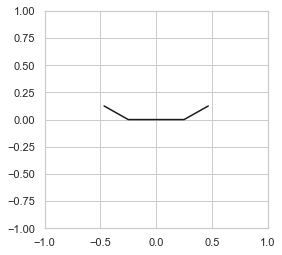

In [5]:
plt.figure(figsize=(4,4))
plt.plot(s.T[0],s.T[1],'k-')
plt.xlim(-1,1); plt.ylim(-1,1);

## Setup

Define the time vector.

In [6]:
dt = 0.01
T = 16
tim = np.arange(0,T,dt)

Let's define $\tau_1 = [0,0,q_1(t)]$ and $\tau_2 = [0,0,q_2(t)]$.

In [7]:
tau = np.array([np.zeros(np.shape(tim)+(3,))]*np.size(r))

In [8]:
def purcell_stroke(tim,shift,power=0.4,strokes=4):
    stroke = np.zeros(np.size(tim))
    step_1 = (tim<0)
    step_2 = (tim<0)
    shift = shift*T/strokes
    for i in np.arange(shift, T, T/strokes):
        step_1 = step_1|((tim>=i)&(tim<i+0.25*T/strokes))
        step_2 = step_2|((tim>=i+0.5*T/strokes)&(tim<i+0.75*T/strokes))
    stroke[step_1] = -power
    stroke[step_2] = power
    return stroke

In [9]:
P = 0.9 #change this to change stroke angle
f = 0.22
tau[1,:,-1] = purcell_stroke(tim,power=P,strokes=4,shift=0)-purcell_stroke(tim,power=f*P,strokes=4,shift=0.25)
tau[0,:,-1] = -purcell_stroke(tim,power=P,strokes=4,shift=0.25)+purcell_stroke(tim,power=f*P,strokes=4,shift=0) 
#shift is measured in stroke fractions
#each stroke is composed of an upward torque, a gap, a downward torque and another gap (equally divided in time)

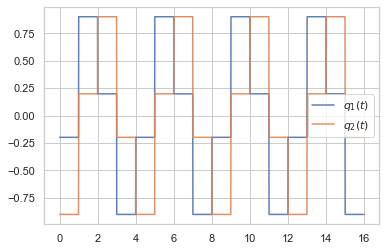

In [10]:
plt.plot(tim,tau[0,:,-1],'-',alpha=0.9);
plt.plot(tim,tau[1,:,-1],'-',alpha=0.9);
plt.legend(["$q_1 (t)$","$q_2 (t)$"]);

In [11]:
R = slts.mesher()

In [12]:
_,pswimmer = slts.evolve(tau,tim,R,r,s,k=100,e=0.3)

In [13]:
fig = plt.figure(figsize = (4.5,4.5))
plt.xlim(-1,1); plt.ylim(-1,1)
camera = Camera(fig)
for i in range(0,np.shape(pswimmer)[0],10):
    plt.plot(pswimmer[i].T[0],pswimmer[i].T[1],'k-', linewidth=2, alpha=0.5, label='_nolegend_')
    plt.plot(np.mean(pswimmer[i].T[0]),np.mean(pswimmer[i].T[1]),'ro', linewidth=2, alpha=0.5)
    camera.snap()
plt.legend(["CoM"])
plt.close()

In [14]:
animation = camera.animate()
animation.save(figfile+"purcell_swimmer.gif",writer = 'imagemagick',fps = 20,dpi=300)
animation